# 期货连续合约(Futures Roll)

因为期货合约大多是有交割期的（也有没有期限的，比如LME三月铜等，后面解释），通常最长的合约期限也不超过一年，为了研究上的方便，很多行情报价系统都设立了“连续合约”。[(摘自百度百科)](https://baike.baidu.com/item/%E8%BF%9E%E7%BB%AD%E5%90%88%E7%BA%A6)

我曾经因为这个问题导致了一个亏损单，很早我刚开始搞一个CTA策略，我回测和实盘都是直接用的未复权的主连数据，实盘时一个主力切换的价格跳空导致了开仓。交易的事情任何一个步骤都不能马虎，主力切换的价差修复一定要考虑到策略里面。

关于主连的统计分布我也想过，因为连续合约是由多个合约切割组合起来的，可能分布都不一样，但是从主观上分析，大部分资金会跟着主力合约走，所以差别应该也不会太大。

关于统计分布的测试，第一篇文章 Standard Bars 已经告诉我们了，volume bars还是非常符合正态分布的。

下面我们来分析一下书中合成连续合约的两种方法，**绝对方法**和**相对方法**

---

Because futures contracts are mostly delivery period (there are no term, such as LME March copper, later explained), usually the longest contract term is not more than one year, for the convenience of research, many market quotation system has set up a "continuous contract." [(From Baidu Encyclopedia)](https://baike.baidu.com/item/%E8%BF%9E%E7%BB%AD%E5%90%88%E7%BA%A6)

I once because of this problem led to a loss order, very early I just started to make a CTA strategy.I used both the backtesting and the online trading when the unadjusted continuous contract data was used. A price jump from contract switch causes an open position on the online trading. Trading things at any step can not be sloppy, the contract switch of spread repair must be taken into account inside the strategy.

The statistical distribution of the continuous contract, because the continuous contract is a combination of multiple contract cutting, may be distributed differently. But subjectively, most of the funds will follow the main contract, so the difference should not be too great.

For the test of statistical distribution, the first article, Standard Bars, has told us that volume Bars is still very normally consistent with the distribution.

Let's take an analysis of the two methods of synthesizing continuous contracts in the book, **absolute methods** and **relative methods**

In [1]:
import sys
import numpy as np
import pandas as pd
from mlfinlab.multi_product import get_futures_roll_series

import seaborn as sns
import matplotlib.pyplot as plt



Support us on Patreon: https://www.patreon.com/HudsonThames

MlFinLab needs you! We need your help for us to keep on maintaining and implementing academic research based on 
financial machine learning (for open-source). In order for us to continue we need to raise $4000 of monthly donations
via Patreon - by December 2020. If we can't reach our goal, we will need to adopt more of a paid for service. We thought
that the best and least impactful course of action (should we not reach our goal) is to leave the package as open-source
but to make the documentation (ReadTheDocs) a paid for service. This is the ultimate litmus test, if the package is a 
value add, then we need the community to help us keep it going.

Our road map for 2020 is to implement the text book: Machine Learning for Asset Managers by Marcos Lopez de Prado, 
as well as a few papers from the Journal of Financial Data Science. We are hiring a full time developer for 3 months 
to help us reach our goals. The money that you

In [5]:
MIN_BAR_FILE_PATH = '../data/rb_continue_min_bar.csv'

In [6]:
# sume function

class Data(object):
    data = None
    
    @staticmethod
    def get():
        if Data.data is None:
            print(f'reading data from {MIN_BAR_FILE_PATH} ...', end='')
            sys.stdout.flush()
            
            df = pd.read_csv(MIN_BAR_FILE_PATH)
            df['datetime'] = pd.to_datetime(df['datetime'])
            df.set_index('datetime', inplace=True)
            Data.data = df
        
            print(f'done')
        else:
            print('Data already in cache')
        return Data.data



In [7]:
df = Data.get()
df.head()

reading data from ../data/rb_continue_min_bar.csv ...done


,open,qfq_close,close,switch_gap,contract
datetime,,,,,
2015-01-05 09:00:00,2550.0,926.0,2554.0,0.0,rb1510
2015-01-05 09:01:00,2555.0,929.0,2557.0,0.0,rb1510
2015-01-05 09:02:00,2556.0,929.0,2557.0,0.0,rb1510
2015-01-05 09:03:00,2556.0,931.0,2559.0,0.0,rb1510
2015-01-05 09:04:00,2559.0,928.0,2556.0,0.0,rb1510


In [8]:
# 获取切换信息
contract_switch_info = df['contract'].drop_duplicates(keep='first')
contract_switch_info = contract_switch_info.index
contract_switch_info

DatetimeIndex(['2015-01-05 09:00:00', '2015-03-06 21:00:00',
               '2015-07-17 21:00:00', '2015-11-03 21:00:00',
               '2016-03-11 21:00:00', '2016-08-17 21:00:00',
               '2016-11-25 21:00:00', '2017-03-22 21:00:00',
               '2017-08-07 21:00:00', '2017-11-08 21:00:00',
               '2018-03-27 21:00:00', '2018-08-16 21:00:00',
               '2018-11-27 21:00:00', '2019-03-29 21:00:00',
               '2019-08-21 21:00:00'],
              dtype='datetime64[ns]', name='datetime', freq=None)

螺纹钢的切换时间通常为3,8,11月

---

The switching time for RB is usually March, August, Nov.

# 用mlfinlab生成连续合约(Build a continuous contract with mlfinlab)

获取合约切换时的缺口的**绝对**值和**相对**值，其实简单来讲绝对方法就是把价差减掉，而相对方法是除法.

---

To get the contract switch ingress with the absolute value and the relative value of the gap.

in fact, the absolute method is to reduce the spread, and the relative method is division.

In [18]:
# Get roll gaps (absolute and relative)ß
roll_gaps_absolute = get_futures_roll_series(df, open_col='open', close_col='close',
                                                   sec_col='contract', current_sec_col='contract', method='absolute')

roll_gaps_relative = get_futures_roll_series(df, open_col='open', close_col='close',
                                                   sec_col='contract', current_sec_col='contract', method='relative')

用获取到的缺口信息生成连续合约

Create a continuous contract with the obtained gap information

In [20]:
continuous_contract = df

# Make a copy of the first contract
continuous_contract_absolute_method = continuous_contract.copy()
continuous_contract_relative_method = continuous_contract.copy()

# Apply the roll gaps
continuous_contract_absolute_method['close'] -= roll_gaps_absolute
continuous_contract_relative_method['close'] /= roll_gaps_relative

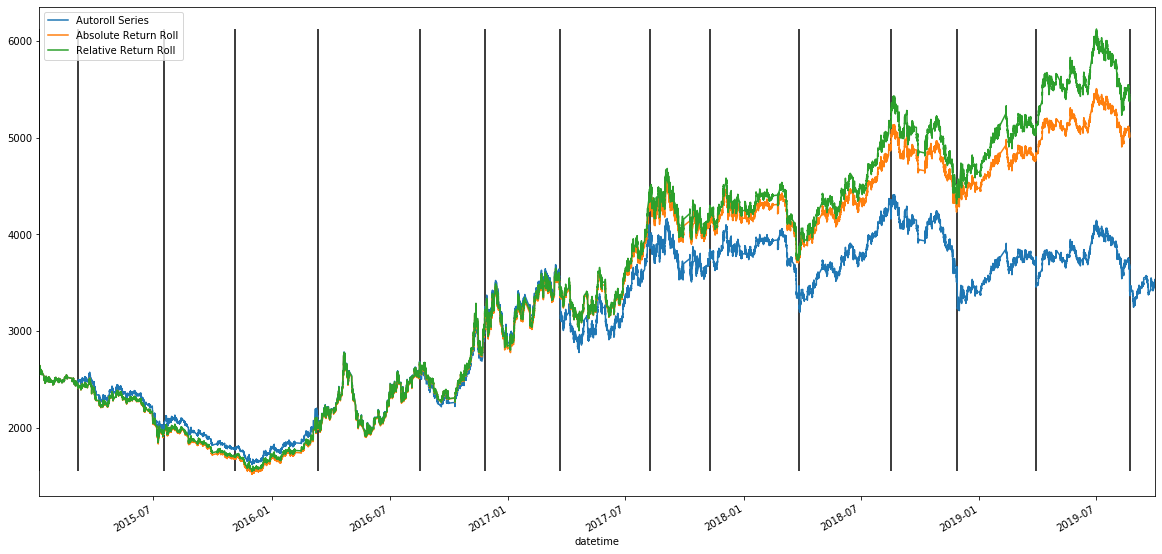

In [38]:
# Plot
plt.figure(figsize=(20, 10))
continuous_contract.close.plot(label = 'Autoroll Series')
continuous_contract_absolute_method.close.plot(label = 'Absolute Return Roll')
continuous_contract_relative_method.close.plot(label = 'Relative Return Roll')
plt.vlines(contract_switch_info, ymin=continuous_contract_relative_method.close.min(), 
           ymax=continuous_contract_relative_method.close.max())
plt.legend(loc='best')
plt.show()

# 我自己生成的连续合约(Continuous contracts generated in my way)

我们可以看到mlfinlab用的两种方式都是后复权的形式，我们一般回测或者实盘用的都是前复权，我自己的连续合约其实就是绝对方法换成后复权。

当前主力合约就是看持仓量的大小。

图中的黑色竖线是合约切换时间。

---

We can see that both methods used by mlfinlab are the form of post split-adjusted. We generally backtest or online trading use are the former forward split-adjusted. My own continuous contract is an absolute method of switching to the forward split-adjusted.

The current main contract is determined by the size of the position.

The black vertical line in the figure is the contract switchtime.

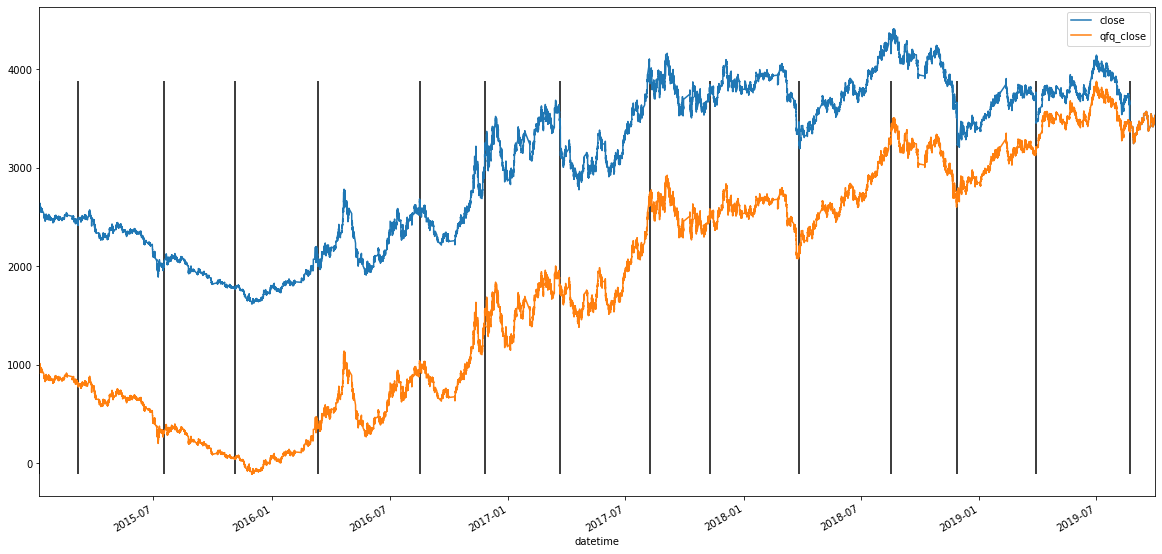

In [39]:
plt.figure(figsize=(20, 10))
df['close'].plot()
df['qfq_close'].plot()
plt.vlines(contract_switch_info, ymin=df['qfq_close'].min(), 
           ymax=df['qfq_close'].max())
plt.legend(loc='best')
plt.show()

和mlfinlab中的Absolute Return Roll是一样的，只是我是往前，他的往后。

这里有一个问题就是采取Absolute复权后的价格出现了负值，这是一个严重的问题(2016-01前后出现了负值价格)，回测时可能会导致计算出错

我们来看一下书中是怎么解决这个问题的

---

It's the same as absolute Return Roll in mlfinlab, just I'm going forward, he's post.

Here's a problem with negative prices after taking Absolute, which is a serious problem (negative prices around 2016-01) and can lead to calculation errors when backtesting and online trading.

Let's see how the book solves the problem.

In [40]:
def get_non_negative_rolled_price(df):
    t_df = df.copy(deep=True)
    t_df['Returns'] = t_df['qfq_close'].diff()/t_df['close'].shift(1)
    t_df['rPrices'] = (1+t_df['Returns']).cumprod()
    return t_df['rPrices']

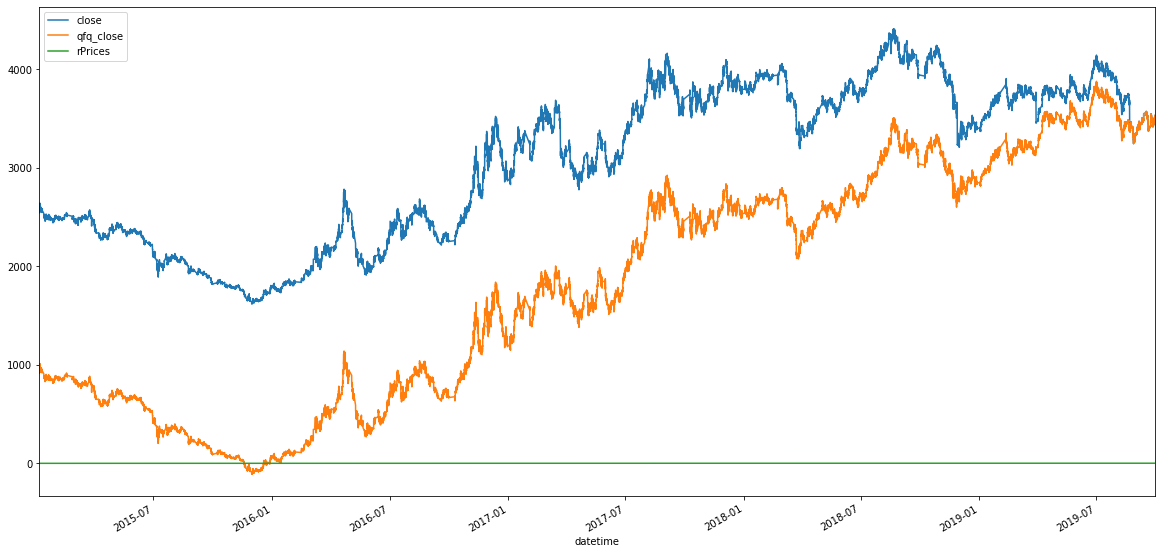

In [42]:
plt.figure(figsize=(20, 10))
df['close'].plot()
df['qfq_close'].plot()
get_non_negative_rolled_price(df).plot()
plt.legend(loc='best')
plt.show()

为什么是一根横线，再去看这段代码这应该是计算的收益率，并不是价格序列，如果要计算价格序列，应该还要乘以本金。

我们来把它转换成价格序列后看是什么样子的。

---

Why is it a horizontal line, and then look at this code this should be calculated to the return, not price sequence, if we want to calculate the price sequence, should also multiply by the price.

Let's turn it into a price sequence and see what it looks like.

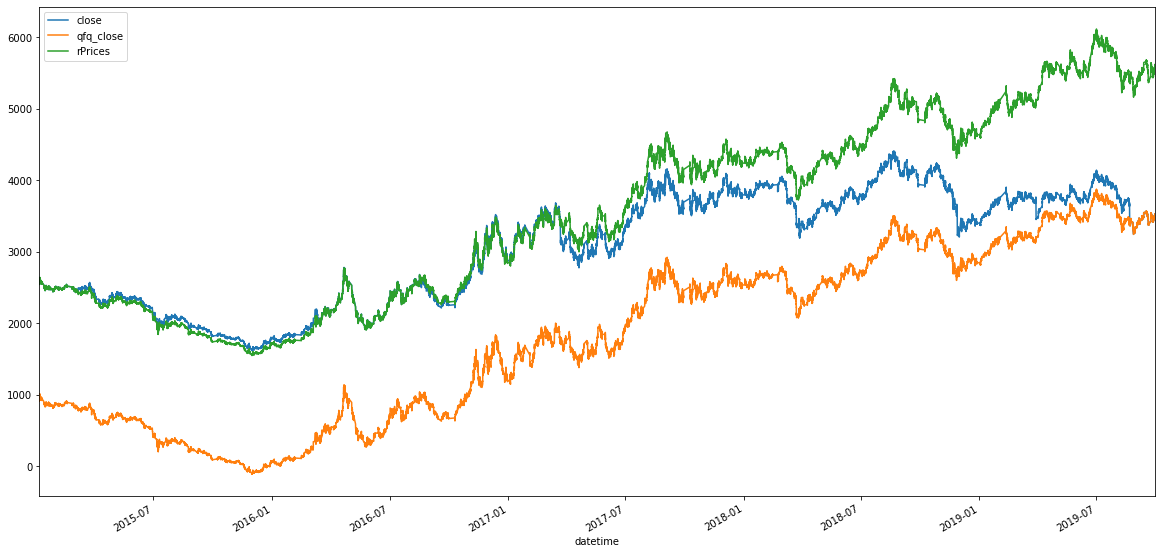

In [45]:
plt.figure(figsize=(20, 10))
df['close'].plot()
df['qfq_close'].plot()
(get_non_negative_rolled_price(df)*df['close'].iloc[0]).plot()
plt.legend(loc='best')
plt.show()

看起来和 relative 方式复权的价格很像。

It looks a lot like the price of the relative-style adjusted.

In [48]:
(get_non_negative_rolled_price(df)*df['close'].iloc[0]).loc['20190701']

datetime
2019-07-01 09:00:00    6091.755799
2019-07-01 09:01:00    6090.279367
2019-07-01 09:02:00    6071.085760
2019-07-01 09:03:00    6071.085760
2019-07-01 09:04:00    6081.420779
                          ...     
2019-07-01 22:55:00    6056.321446
2019-07-01 22:56:00    6057.797877
2019-07-01 22:57:00    6060.750740
2019-07-01 22:58:00    6060.750740
2019-07-01 22:59:00    6062.227171
Name: rPrices, Length: 345, dtype: float64

In [49]:
continuous_contract_relative_method['close'].loc['20190701']

datetime
2019-07-01 09:00:00    6095.805506
2019-07-01 09:01:00    6094.328093
2019-07-01 09:02:00    6075.121726
2019-07-01 09:03:00    6075.121726
2019-07-01 09:04:00    6085.463616
                          ...     
2019-07-01 22:55:00    6060.347597
2019-07-01 22:56:00    6061.825010
2019-07-01 22:57:00    6064.779835
2019-07-01 22:58:00    6064.779835
2019-07-01 22:59:00    6066.257248
Name: close, Length: 345, dtype: float64

简单比对一下数据，rPrices和relative方式复权的数据还是有点不一样。

我不知道计算returns时，为什么要用roll后的价差除以原始价格，我对这一点并不认同。或许可以只是把原始序列计算出来的return中，把切换时的异常值处理一下即可。

---

For a simple comparison of data, rPrices and relative data are not the same.

I don't know why he would use the spread after roll to divide the original price when calculating returns, and I don't agree with that. Perhaps you can just calculate the original sequence in the return, the switch time outliers can be processed.

# 复权主连数据在回测或者实盘时的使用(Experience in the use of continuous contract in  backtesting or online trading )

回测的一个重要的准则就是越接近实盘越好，这样出来的结果可信度就越高。那么复权后的数据能直接用于回测吗？或许可以用不复权的数据回测？

不复权肯定是不行的，要么不用主连，用单个合约倒是可以。不然主连数据不复权，主力切换时的价差就是虚假数据，可能会产生错误的信号。回测显示吃了这个价差赚了一笔，实际环境是赚不了的。

当然这也取决于产生信号的方式是什么，也就是怎么对close,open这些信息进行计算。

我一般会写一个小程序进行验证，假如我的计算函数是 calc_signal，我会再写一个calc_signal_backtest。calc_signal会模拟实盘在每个切换点都对之前的行情数据重新进行计算，而calc_singal_backtest 为了加快回测的速度会一次性计算完毕。

比如计算ewm，pandas自带这个函数可以一次性计算完毕，但是对于复权后的数据这么计算要小心，像我的测试数据是2015\~2020，在2015\~2016年间前复权后价格和真实价格相差还是很大的，计算出来的信号值可能不一样。

这时我的calc_signal会循环计算ewm，和实盘一样，在2016.01.01时只用这之前的数据进行计算，最后对比一下会两种计算的结果差别大不大。

如果差别不大用向量化计算就行，为什么不直接用实盘一样的循环计算方法？因为太慢了，而向量化计算快太多，进行参数优化时就知道其中的坑了。

如果差别很大，那只能用循环计算的方法，准确度第一。

实际经验中，有些指标可以向量化计算，有些不行，具体问题具体分析。

当然循环计算也有一个相对快一点的方法，不用每一根bar循环，只在切换点重新计算，细节这里不讲了，这篇写得太啰嗦了。

---

An important criterion for backtesting is that the closer you get to the real, the better, the more credible the result is. So can the adjusted data be used directly for backtesting? Perhaps you can backtest with unadjusted data?

It is not possible not to adjust, or not to have a continuous contract, just a single contract. Otherwise, the data of the continuous contract is not adjusted, the spread when the main switch is the junk data, may produce the wrong signal. The backtest shows that the profit caused by this spread is not earned on the online environment.

Of course, it also depends on how the signal is generated, that is, how close, open information is calculated.

I usually write a small program for validation. If my calculation function is calc_signal, I'll write another calc_signal_backtest. calc_signal simulates a real disk recalculating the previous market data at each switching point, while calc_singal_backtest will be calculated at once to speed up the backtesting.

For example, to calculate ewm, pandas bring this function can be calculated at once. But be careful about how the data after the restoration is calculated. Like my test data is 2015-2020, the difference between the forward adjusted price and the real price between 2015 and 2016 is still very large, the calculated signal value may be different.

At this point my calc_signal will cycle ewm, the same as the real plate. Finally, I'll compare the differences between the two calculations.

If the difference is not much, it's ok to use the vectorized calculation. Why not just use the same circular calculation method as online trading? Because it's too slow. And the vectorized is too fast, when the parameter optimization will know the pits.

If there is a big difference, it can only be calculated by a circular method, the accuracy is the first.

In practical experience, some indicators can be vectorized calculated, some can not, specific problems are analyzed.

Of course, there is also a relatively quick way of cycling calculation, do not use every bar loop, only at the switchpoint recalculation. Details here do not say, this is written too long.